In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette('viridis')

from pyspark import SparkContext
from table import Table

# start spark with 1 worker thread
sc = SparkContext("local[*]")
sc.setLogLevel("ERROR")

21/11/21 16:34:01 WARN Utils: Your hostname, pasokon resolves to a loopback address: 127.0.1.1; using 192.168.1.96 instead (on interface wlo1)
21/11/21 16:34:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/11/21 16:34:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### What is the distribution of the machines according to their CPU capacity?

In [2]:
machine_events = Table('machine_events', sc)
machine_events.pprint(take=5)

,time,machine_id,event_type,platform_id,cpus,memory
0,0,5,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
1,0,6,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
2,0,7,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
3,0,10,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
4,0,13,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493


In [3]:
cpu_dist = machine_events.select(['cpus','memory']).countByValue()
cpu_dist

defaultdict(int,
            {('0.5', '0.2493'): 10188,
             ('0.5', '0.4995'): 21731,
             ('0.5', '0.1241'): 97,
             ('0.5', '0.03085'): 6,
             ('0.5', '0.749'): 2983,
             ('0.5', '0.9678'): 7,
             ('0.25', '0.2498'): 510,
             ('0.5', '0.06158'): 3,
             ('1', '1'): 2218,
             ('1', '0.5'): 5,
             ('NA', 'NA'): 32})

In [4]:
cpu_dist = machine_events.select(['cpus']).countByValue()
for cpu_type, value in cpu_dist.items():
    print(f'cpu type: {cpu_type[0]}, count: {value}')

cpu type: 0.5, count: 35015
cpu type: 0.25, count: 510
cpu type: 1, count: 2223
cpu type: NA, count: 32


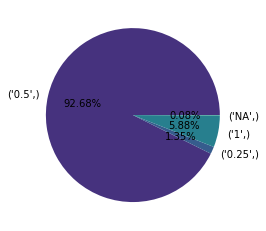

In [6]:
plt.pie(cpu_dist.values(), labels=cpu_dist.keys(), colors = colors, autopct='%.2f%%')
plt.show()


### On average, how many tasks compose a job?

In [7]:
import numpy as np
task_events = Table('task_events', sc)
job = task_events.select(['job_id'])
task_per_job = list(job.countByValue().values())

np.mean(task_per_job), np.std(task_per_job) 

(91.96036772216547, 843.9305821206359)

In [8]:
task_events.pprint(5)

,time,missing_info,job_id,task_index,machine_id,event_type,user,scheduling_class,priority,cpu_request,memory_request,disk_space_request,different_machines_restriction
0,0,2,3418309,0,4155527081,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NA,NA,NA,NA
1,0,2,3418309,1,329150663,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NA,NA,NA,NA
2,0,NA,3418314,0,3938719206,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.125,0.07446,0.0004244,0
3,0,NA,3418314,1,351618647,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.125,0.07446,0.0004244,0
4,0,2,3418319,0,431052910,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NA,NA,NA,NA


In [9]:
task_events.select(['job_id', 'scheduling_class']).take(5)

[('3418309', '3'),
 ('3418309', '3'),
 ('3418314', '3'),
 ('3418314', '3'),
 ('3418319', '3')]

## What is the distribution of the number jobs/tasks per scheduling class?

In [10]:
task_events.pprint(10)

,time,missing_info,job_id,task_index,machine_id,event_type,user,scheduling_class,priority,cpu_request,memory_request,disk_space_request,different_machines_restriction
0,0,2,3418309,0,4155527081,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NA,NA,NA,NA
1,0,2,3418309,1,329150663,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NA,NA,NA,NA
2,0,NA,3418314,0,3938719206,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.125,0.07446,0.0004244,0
3,0,NA,3418314,1,351618647,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.125,0.07446,0.0004244,0
4,0,2,3418319,0,431052910,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NA,NA,NA,NA
5,0,2,3418319,1,257348783,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NA,NA,NA,NA
6,0,2,3418324,0,5655258253,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NA,NA,NA,NA
7,0,2,3418324,1,3550322224,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NA,NA,NA,NA
8,0,2,3418329,0,1303745,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NA,NA,NA,NA
9,0,2,3418329,1,3894543095,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NA,NA,NA,NA


In [41]:
job_task_sched = task_events.select(['scheduling_class','job_id', 'task_index'])\
    .map(lambda x: (x[0], (x[1],x[2])))
job_task_sched.take(5)

[('3', ('3418309', '0')),
 ('3', ('3418309', '1')),
 ('3', ('3418314', '0')),
 ('3', ('3418314', '1')),
 ('3', ('3418319', '0'))]

In [64]:
def to_list(a):
    return [[a[0]], [a[1]]]

def append(a, b):
    a[0].append(b[0])
    a[1].append(b[1])
    return [a[0], a[1]]

def extend(a, b):
    a[0].extend(b[0])
    a[1].extend(b[1])
    return [a[0], a[1]]

[('b', 2), ('a', 2)]

In [66]:
job_task_sched.combineByKey(to_list, append, extend).map(
    lambda x: (x[0], len(set(x[1][0])), len(x[1][1]))
).collect()

[('1', 1624, 58109), ('0', 919, 237969), ('3', 933, 56586), ('2', 1419, 97482)]